In [0]:
import os
import cv2
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from os.path import exists, join, basename
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications import ResNet50, VGG16, MobileNetV2, NASNetMobile
from tensorflow.python.keras.models import Sequential
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout

#plt.style.use('fivethirtyeight')

In [0]:
cwd = os.getcwd()

In [0]:
dataset_name = join(cwd, 'warwick_qu_dataset_released_2016_07_08')
if not exists(dataset_name + '.zip'):
  get_ipython().system('wget https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip')

--2019-09-13 06:21:16--  https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 180902609 (173M) [application/zip]
Saving to: ‘warwick_qu_dataset_released_2016_07_08.zip’

warwick_qu_dataset_ 100%[===================>] 172.52M  19.4MB/s    in 9.3s    

2019-09-13 06:21:26 (18.6 MB/s) - ‘warwick_qu_dataset_released_2016_07_08.zip’ saved [180902609/180902609]



In [0]:
dataset_dir = join(cwd, 'Warwick QU Dataset (Released 2016_07_08)')
if not exists(dataset_dir):
  get_ipython().system('unzip ' + dataset_name + '.zip')

Archive:  /content/warwick_qu_dataset_released_2016_07_08.zip
   creating: Warwick QU Dataset (Released 2016_07_08)/
  inflating: Warwick QU Dataset (Released 2016_07_08)/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/Warwick QU Dataset (Released 2016_07_08)/
  inflating: __MACOSX/Warwick QU Dataset (Released 2016_07_08)/._.DS_Store  
  inflating: Warwick QU Dataset (Released 2016_07_08)/Grade.csv  
  inflating: __MACOSX/Warwick QU Dataset (Released 2016_07_08)/._Grade.csv  
  inflating: Warwick QU Dataset (Released 2016_07_08)/testA_1.bmp  
  inflating: __MACOSX/Warwick QU Dataset (Released 2016_07_08)/._testA_1.bmp  
  inflating: Warwick QU Dataset (Released 2016_07_08)/testA_10.bmp  
  inflating: __MACOSX/Warwick QU Dataset (Released 2016_07_08)/._testA_10.bmp  
  inflating: Warwick QU Dataset (Released 2016_07_08)/testA_10_anno.bmp  
  inflating: __MACOSX/Warwick QU Dataset (Released 2016_07_08)/._testA_10_anno.bmp  
  inflating: Warwick QU Dataset (Released 2016_07_08)/t

In [0]:
data = pd.read_csv(join(dataset_dir, 'Grade.csv')) 
data = data.rename(columns={data.columns[2]: 'label'})
data = data[['name', 'label']]
data['name'] = [name + '.bmp' for name in data['name']]
#print(data.columns[2])
data.head()

,name,label
0,testA_1.bmp,benign
1,testA_10.bmp,benign
2,testA_11.bmp,benign
3,testA_12.bmp,malignant
4,testA_13.bmp,malignant


[' malignant', ' benign']


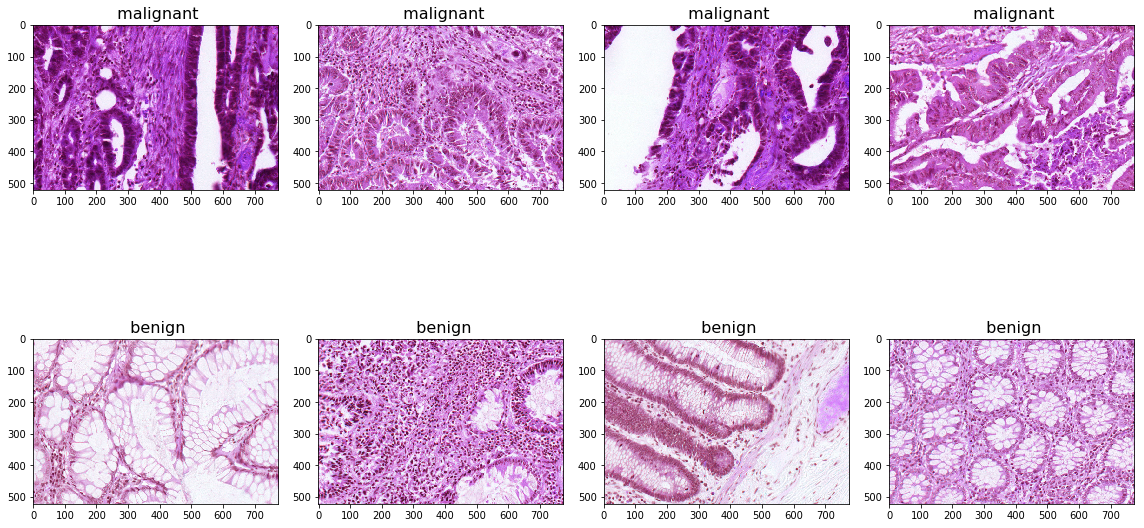

In [0]:
class ImageViewer:
    def read_img(self,id):
        """
        Read image by it's id
        """
        file = dataset_dir + '/' + str(id)
        im=cv2.imread(file)
        return im

    def draw_sample_images(self):
        """
        Draw malignant and healthy benign for EDA
        """
        ncols=4
        f, ax = plt.subplots(nrows=2,ncols=ncols, 
                             figsize=(4*ncols,5*2))
        i=-1
        captions = list(set(data['label']))
        print(captions)
        # Draw one row for malignant, one row for benign images
        for label in captions:
            i=i+1
            samples = data[data['label']==label]['name'].sample(ncols).values
            for j in range(0,ncols):
                file_id=samples[j]
                im=self.read_img(file_id)
                ax[i, j].imshow(im)
                ax[i, j].set_title(captions[i], fontsize=16)  
        plt.tight_layout()
        plt.show()
    
ImageViewer().draw_sample_images()

## Quick EDA (Exploratory Data Analysis)

In [0]:
def eda(df):
  df.label.value_counts().plot(kind='bar')
  plt.title('Labels counts')
  plt.xlabel('Label')
  plt.ylabel('Count')
  plt.show()

(85, 2)


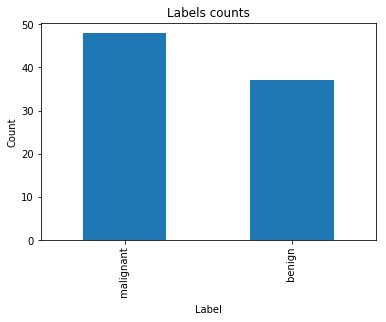

,name,label
80,train_1.bmp,malignant
81,train_10.bmp,malignant
82,train_11.bmp,malignant
83,train_12.bmp,benign
84,train_13.bmp,malignant


In [0]:
train_df = data[data.name.str.startswith('train')]
print(train_df.shape)
eda(train_df)
train_df.head()

(60, 2)


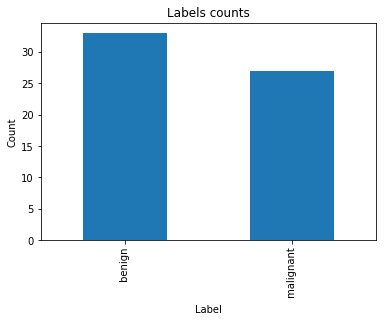

,name,label
0,testA_1.bmp,benign
1,testA_10.bmp,benign
2,testA_11.bmp,benign
3,testA_12.bmp,malignant
4,testA_13.bmp,malignant


In [0]:
valid_df = data[data.name.str.startswith('testA')]
print(valid_df.shape)
eda(valid_df)
valid_df.head()

(20, 2)


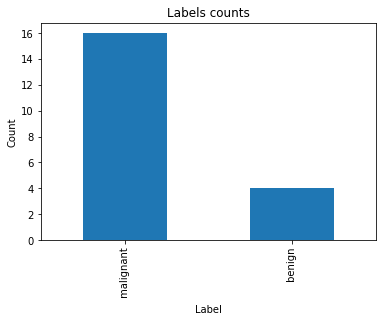

,name,label
60,testB_1.bmp,malignant
61,testB_10.bmp,malignant
62,testB_11.bmp,malignant
63,testB_12.bmp,malignant
64,testB_13.bmp,malignant


In [0]:
test_df = data[data.name.str.startswith('testB')]
print(test_df.shape)
eda(test_df)
test_df.head()

In [0]:
image_size = 224
train_datagen=ImageDataGenerator(rescale=1./255,
                                 featurewise_center=False,
                                 featurewise_std_normalization=False,
                                 rotation_range=90,
                                 zoom_range=0.15, 
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.15,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode="nearest")

test_datagen=ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
                                              directory = dataset_dir,
                                              x_col = "name",
                                              y_col = 'label',
                                              class_mode = "binary",
                                              shuffle = True,
                                              target_size = (image_size,image_size),
                                              batch_size = 16)

valid_generator = test_datagen.flow_from_dataframe(dataframe = valid_df,
                                              directory = dataset_dir,
                                              x_col = "name",
                                              y_col = 'label',
                                              class_mode = "binary",
                                              shuffle = True,
                                              target_size = (image_size,image_size),
                                              batch_size = 16)

test_generator = test_datagen.flow_from_dataframe(dataframe = test_df,
                                              directory = dataset_dir,
                                              x_col = "name",
                                              y_col = 'label',
                                              class_mode = "binary",
                                              target_size = (image_size,image_size),
                                              batch_size = 16)

Found 85 validated image filenames belonging to 2 classes.
Found 60 validated image filenames belonging to 2 classes.
Found 20 validated image filenames belonging to 2 classes.


In [0]:
model = Sequential()

model.add(MobileNetV2(input_shape= (image_size, image_size, 3), include_top=False, pooling='avg'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].trainable = False
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
9412608/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,575,873
Trainable params: 1,315,329
Non-trainable params:

In [0]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'sgd',
              metrics=['accuracy'])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
5/5 [==============================] - 7s 1s/step - loss: 0.7295 - acc: 0.6087 - val_loss: 0.6644 - val_acc: 0.6875
Epoch 2/50
5/5 [==============================] - 1s 204ms/step - loss: 0.4804 - acc: 0.7625 - val_loss: 0.6239 - val_acc: 0.6667
Epoch 3/50
5/5 [==============================] - 1s 178ms/step - loss: 0.3948 - acc: 0.8406 - val_loss: 0.5820 - val_acc: 0.7292
Epoch 4/50
5/5 [==============================] - 1s 168ms/step - loss: 0.5238 - acc: 0.7681 - val_loss: 0.5671 - val_acc: 0.7708
Epoch 5/50
5/5 [==============================] - 1s 182ms/step - loss: 0.4691 - acc: 0.7826 - val_loss: 0.5510 - val_acc: 0.7917
Epoch 6/50
5/5 [==============================] - 1s 170ms/step - loss: 0.3932 - acc: 0.8261 - val_loss: 0.5617 - val_acc: 0.7292
Epoch 7/50
5/5 [==============================] - 1s 172ms/step - loss: 0.2263 - acc: 0.9275 - val_loss: 0.5280 - val_acc: 0.7292

In [0]:
def plot_history(history):
  """
  Plot training history
        """
  ## Trained model analysis and evaluation
  f, ax = plt.subplots(1,2, figsize=(12,3))
  ax[0].plot(history.history['loss'], label="Loss")
  ax[0].plot(history.history['val_loss'], label="Validation loss")
  ax[0].set_title('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[0].legend()

  # Accuracy
  ax[1].plot(history.history['acc'], label="Accuracy")
  ax[1].plot(history.history['val_acc'], label="Validation accuracy")
  ax[1].set_title('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()
  plt.tight_layout()
  plt.show()

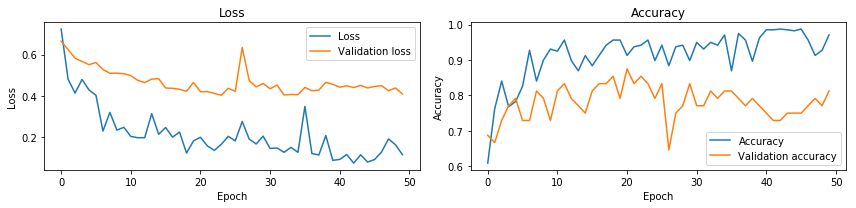

In [0]:
plot_history(history)

In [0]:
print(model.metrics_names)
print(model.evaluate_generator(test_generator))

['loss', 'acc']
[0.20945080509409308, 0.85]


In [0]:
from __future__ import print_function

import time
import numpy as np
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import layers
from keras.applications import vgg16
from keras import backend as K


def normalize(x):
    """utility function to normalize a tensor.

    # Arguments
        x: An input tensor.

    # Returns
        The normalized input tensor.
    """
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.

    # Arguments
        x: A numpy-array representing the generated image.

    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):
    """utility function to convert a valid uint8 image back into a float array.
       Reverses `deprocess_image`.

    # Arguments
        x: A numpy-array, which could be used in e.g. imshow.
        former: The former numpy-array.
                Need to determine the former mean and variance.

    # Returns
        A processed numpy-array representing the generated image.
    """
    if K.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()


def visualize_layer(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(412, 412),
                    filter_range=(0, None)):
    """Visualizes the most relevant filters of one conv-layer in a certain model.

    # Arguments
        model: The model containing layer_name.
        layer_name: The name of the layer to be visualized.
                    Has to be a part of model.
        step: step size for gradient ascent.
        epochs: Number of iterations for gradient ascent.
        upscaling_steps: Number of upscaling steps.
                         Starting image is in this case (80, 80).
        upscaling_factor: Factor to which to slowly upgrade
                          the image towards output_dim.
        output_dim: [img_width, img_height] The output image dimensions.
        filter_range: Tupel[lower, upper]
                      Determines the to be computed filter numbers.
                      If the second value is `None`,
                      the last filter will be inferred as the upper boundary.
    """

    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):
        """Generates image for one particular filter.

        # Arguments
            input_img: The input-image Tensor.
            layer_output: The output-image Tensor.
            filter_index: The to be processed filter number.
                          Assumed to be valid.

        #Returns
            Either None if no image could be generated.
            or a tuple of the image (array) itself and the last loss.
        """
        s_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random(
                (1, 3, intermediate_dim[0], intermediate_dim[1]))
        else:
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them
                if loss_value <= K.epsilon():
                    return None

            # Calulate upscaled dimension
            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            # Upscale
            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = [process_image(img, input_img_data[0])]

        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        e_time = time.time()
        print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  loss_value,
                                                                  e_time - s_time))
        return img, loss_value

    def _draw_filters(filters, n=None):
        """Draw the best filters in a nxn grid.

        # Arguments
            filters: A List of generated images and their corresponding losses
                     for each processed filter.
            n: dimension of the grid.
               If none, the largest possible square will be used
        """
        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))

        # the filters that have the highest loss are assumed to be better-looking.
        # we will only keep the top n*n filters.
        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]

        # build a black picture with enough space for
        # e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
        MARGIN = 5
        width = n * output_dim[0] + (n - 1) * MARGIN
        height = n * output_dim[1] + (n - 1) * MARGIN
        stitched_filters = np.zeros((width, height, 3), dtype='uint8')

        # fill the picture with our saved filters
        for i in range(n):
            for j in range(n):
                img, _ = filters[i * n + j]
                width_margin = (output_dim[0] + MARGIN) * i
                height_margin = (output_dim[1] + MARGIN) * j
                stitched_filters[
                    width_margin: width_margin + output_dim[0],
                    height_margin: height_margin + output_dim[1], :] = img

        # save the result to disk
        save_img('vgg_{0:}_{1:}x{1:}.png'.format(layer_name, n), stitched_filters)

    # this is the placeholder for the input images
    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    output_layer = layer_dict[layer_name]
    assert isinstance(output_layer, layers.Conv2D)

    # Compute to be processed filter range
    filter_lower = filter_range[0]
    filter_upper = (filter_range[1]
                    if filter_range[1] is not None
                    else len(output_layer.get_weights()[1]))
    assert(filter_lower >= 0
           and filter_upper <= len(output_layer.get_weights()[1])
           and filter_upper > filter_lower)
    print('Compute filters {:} to {:}'.format(filter_lower, filter_upper))

    # iterate through each filter and generate its corresponding image
    processed_filters = []
    for f in range(filter_lower, filter_upper):
        img_loss = _generate_filter_image(input_img, output_layer.output, f)

        if img_loss is not None:
            processed_filters.append(img_loss)

    print('{} filter processed.'.format(len(processed_filters)))
    # Finally draw and store the best filters to disk
    _draw_filters(processed_filters)


if __name__ == '__main__':
    # the name of the layer we want to visualize
    # (see model definition at keras/applications/vgg16.py)
    LAYER_NAME = 'block5_conv1'

    # build the VGG16 network with ImageNet weights
    vgg = vgg16.VGG16(weights='imagenet', include_top=False)
    print('Model loaded.')
    vgg.summary()

    # example function call
    visualize_layer(vgg, LAYER_NAME)

Using TensorFlow backend.






58892288/58889256 [==============================] - 1s 0us/step


Model loaded.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
__________________________________________